## Caricamento librerie e file

In [0]:
%tensorflow_version  2.x
! pip install -q keras==2.3.0

TensorFlow 2.x selected.
     |████████████████████████████████| 378kB 3.0MB/s 


In [0]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-jhezce0m
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-jhezce0m
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=b97fb55e514d6657295333e65ed211cfbf60d5b94df5bc5d062a31c841f8c9c5
  Stored in directory: /tmp/pip-ephem-wheel-cache-nn18m1qg/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


### Caricamento librerie

In [0]:
import os
import numpy as np
import random
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import cv2 as cv
import re
import IPython.display as ipd
import joblib

# SKLEARN
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# KERAS
import keras
from keras.models import Model, load_model
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import AveragePooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.optimizers import adam
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


### Caricamento file da Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# unzip immagini senza augmentation
!unzip -qq "/content/drive/My Drive/Progetto DSIM/Video/Dati/Dataset_Fotografie_Cascade2.zip"

# unzip immagini con augmentation
!unzip -qq "/content/drive/My Drive/Progetto DSIM/Video/Dati/Dataset_Fotografie_Cascade_2.zip"

### Funzione di caricamento dei dati

In [0]:
def load_data(dir = './Dataset_Fotografie_Cascade/'):
  labels = []
  immagini = []
  temp = re.compile("([a-zA-Z]+)([0-9]+)") 

  # caricamento immagini scattate 
  for f in tqdm(sorted(os.listdir(dir))):
    if f.endswith('.png'):
      imm = cv.cvtColor(cv.imread(dir + f), cv.COLOR_BGR2GRAY)
      imm = np.array(imm)
      imm = cv.resize(imm, (256, 256))
      immagini.append(imm)
      # creazione label
      res = temp.match(f).groups()[0]
      if res == "d":
        labels.append(int(0))
      else:
        labels.append(int(1))
  return np.array(immagini), np.array(labels)

## Immagini senza augmentation

### Caricamento Dataset immagini

In [0]:
immagini, labels = load_data()

100%|██████████| 799/799 [00:01<00:00, 594.87it/s]


<Figure size 720x720 with 0 Axes>

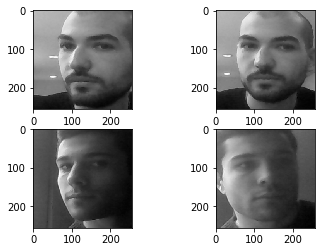

In [0]:
# print immagini di esempio
plt.figure(figsize=(10,10))
f, axarr = plt.subplots(2,2) 
axarr[0,0].imshow(immagini[12], cmap = 'gray')
axarr[0,1].imshow(immagini[1], cmap = 'gray')
axarr[1,0].imshow(immagini[406], cmap = 'gray')
axarr[1,1].imshow(immagini[416], cmap = 'gray')

### Train-Test Split

In [0]:
# Train-test split (80-20)
x_train, x_test, y_train, y_test = train_test_split(immagini, labels, test_size=0.2, random_state=2020, shuffle = True)

# Normalizzazione
x_train = np.array(x_train)/255.0
x_test = np.array(x_test)/255.0

# Reshape
x_train = x_train.reshape(-1, 256, 256, 1)
x_test = x_test.reshape(-1, 256, 256, 1)

In [0]:
print("Train shape: " + str(np.array(x_train).shape) + " " + str(np.array(y_train).shape))
print("Test shape: " + str(np.array(x_test).shape) + " " + str(np.array(y_test).shape))

Train shape: (639, 256, 256, 1) (639,)
Test shape: (160, 256, 256, 1) (160,)


### Modello CNN

In [0]:
input_shape = x_train[0].shape

# Definizione modello
model = Sequential()

# Primo conv
model.add(Conv2D(8,
                 kernel_size=(2,2),
                 activation='relu',
                 input_shape=input_shape))
# Secondo conv
model.add(Conv2D(8, kernel_size = (2,2), activation="relu"))
# Terzo conv
model.add(Conv2D(8, kernel_size = (2,2), activation="relu"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.3))

# Flatten
model.add(Flatten())

# Dense
model.add(Dropout(0.3))
model.add(Dense(2, activation = "softmax"))

print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 255, 255, 8)       40        
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 254, 254, 8)       264       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 253, 253, 8)       264       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 126, 126, 8)       0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 126, 126, 8)       0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 127008)            0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 127008)           

In [0]:
# Compilazione modello
model.compile(optimizer = keras.optimizers.Adam(lr=0.00001),
            loss = "sparse_categorical_crossentropy",
            metrics = ["accuracy"])

# Train e test modello
mcp_save = ModelCheckpoint('model-imm-2(96%-0OF).hdf5',
                          save_best_only=True,
                          monitor='val_loss',
                          mode='min')

network_history = model.fit(x_train, y_train,
                        batch_size= 32,
                        epochs= 100,
                        verbose = 1,
                        validation_split = 0.2,
                        callbacks = [mcp_save])

Train on 511 samples, validate on 128 samples
Epoch 1/100
511/511 [==============================] - 2s 3ms/step - loss: 0.6936 - accuracy: 0.5147 - val_loss: 0.6893 - val_accuracy: 0.5859
Epoch 2/100
511/511 [==============================] - 1s 3ms/step - loss: 0.6863 - accuracy: 0.5460 - val_loss: 0.6870 - val_accuracy: 0.4609
Epoch 3/100
511/511 [==============================] - 1s 3ms/step - loss: 0.6782 - accuracy: 0.5245 - val_loss: 0.6816 - val_accuracy: 0.4609
Epoch 4/100
511/511 [==============================] - 1s 3ms/step - loss: 0.6732 - accuracy: 0.5303 - val_loss: 0.6762 - val_accuracy: 0.4609
Epoch 5/100
511/511 [==============================] - 1s 3ms/step - loss: 0.6668 - accuracy: 0.5793 - val_loss: 0.6684 - val_accuracy: 0.6172
Epoch 6/100
511/511 [==============================] - 1s 3ms/step - loss: 0.6592 - accuracy: 0.6634 - val_loss: 0.6620 - val_accuracy: 0.6641
Epoch 7/100
511/511 [==============================] - 1s 3ms/step - loss: 0.6549 - accuracy: 0.

#### Valutazione miglior modello

In [0]:
loaded_model = load_model("model-imm-2(96%-0OF).hdf5")
loaded_model.evaluate(x_test, y_test, verbose=0)

[0.2090168923139572, 0.9375]

In [0]:
print(classification_report(y_test, loaded_model.predict_classes(x_test)))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94        81
           1       0.97      0.90      0.93        79

    accuracy                           0.94       160
   macro avg       0.94      0.94      0.94       160
weighted avg       0.94      0.94      0.94       160



#### Grafico Train

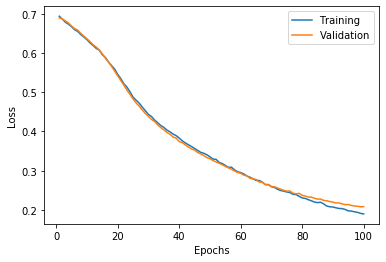

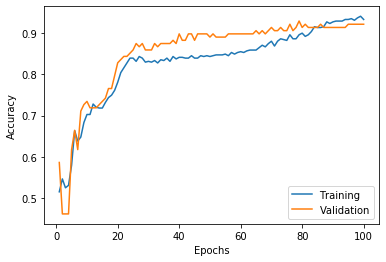

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

x_plot = list(range(1,len(network_history.epoch)+1))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
plot_history(network_history)

## Immagini con augmentation (manuale)

### Caricamento Dataset immagini Augmented

In [0]:
immagini, labels = load_data("./Dataset_Fotografie_Cascade_2/")

100%|██████████| 1000/1000 [00:01<00:00, 650.74it/s]


<Figure size 720x720 with 0 Axes>

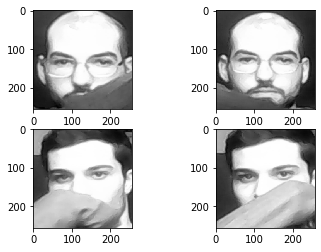

In [0]:
# print immagini di esempio
plt.figure(figsize=(10,10))
f, axarr = plt.subplots(2,2) 
axarr[0,0].imshow(immagini[440], cmap = 'gray')
axarr[0,1].imshow(immagini[442], cmap = 'gray')
axarr[1,0].imshow(immagini[910], cmap = 'gray')
axarr[1,1].imshow(immagini[912], cmap = 'gray')

###Train-Test Split

In [0]:
# Train-Test split (80-20)
x_train, x_test, y_train, y_test = train_test_split(immagini, labels, test_size=0.2, random_state=2020, shuffle = True)

# Normalizzazione
x_train = np.array(x_train)/255.0
x_test = np.array(x_test)/255.0

# Reshape
x_train = x_train.reshape(-1, 256, 256, 1)
x_test = x_test.reshape(-1, 256, 256, 1)

In [0]:
print("Train shape: " + str(np.array(x_train).shape) + " " + str(np.array(y_train).shape))
print("Test shape: " + str(np.array(x_test).shape) + " " + str(np.array(y_test).shape))

Train shape: (800, 256, 256, 1) (800,)
Test shape: (200, 256, 256, 1) (200,)


### Modello CNN

In [0]:
input_shape = x_train[0].shape

# Definizione modello
model = Sequential()

# Primo conv
model.add(Conv2D(32,
                 kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
# Secondo conv
model.add(Conv2D(16, kernel_size = (3, 3), activation="relu"))
# Terzo conv
model.add(Conv2D(8, kernel_size = (3, 3), activation="relu"))
# Quarto conv
model.add(Conv2D(8, kernel_size = (3, 3), activation="relu"))
model.add(MaxPooling2D((3, 3)))
model.add(Dropout(0.4))

# Flatten
model.add(Flatten())

# Dense
model.add(Dropout(0.4))
model.add(Dense(2, activation = "softmax"))


print(model.summary())

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_83 (Conv2D)           (None, 254, 254, 32)      320       
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 252, 252, 16)      4624      
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 250, 250, 8)       1160      
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 248, 248, 8)       584       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 82, 82, 8)         0         
_________________________________________________________________
dropout_75 (Dropout)         (None, 82, 82, 8)         0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 53792)           

In [0]:
# Compilazione modello
model.compile(optimizer = keras.optimizers.Adam(lr=0.0001),
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

# Train e test modello
mcp_save = ModelCheckpoint('model-imm-aug-3.hdf5',
                          save_best_only=True,
                          monitor='val_loss',
                          mode='min')

network_history = model.fit(x_train, np.array(y_train),
                      batch_size= 16,
                      epochs= 150,
                      verbose = 1,
                      validation_split = 0.2,
                      callbacks = [mcp_save])

Train on 640 samples, validate on 160 samples
Epoch 1/150
640/640 [==============================] - 4s 7ms/step - loss: 0.6664 - accuracy: 0.5844 - val_loss: 0.6536 - val_accuracy: 0.6187
Epoch 2/150
640/640 [==============================] - 4s 6ms/step - loss: 0.5813 - accuracy: 0.6906 - val_loss: 0.6171 - val_accuracy: 0.6250
Epoch 3/150
640/640 [==============================] - 4s 6ms/step - loss: 0.5023 - accuracy: 0.7500 - val_loss: 0.5593 - val_accuracy: 0.7375
Epoch 4/150
640/640 [==============================] - 4s 6ms/step - loss: 0.4046 - accuracy: 0.8281 - val_loss: 0.4385 - val_accuracy: 0.8125
Epoch 5/150
640/640 [==============================] - 4s 6ms/step - loss: 0.3329 - accuracy: 0.8766 - val_loss: 0.3932 - val_accuracy: 0.8313
Epoch 6/150
640/640 [==============================] - 4s 6ms/step - loss: 0.2901 - accuracy: 0.8734 - val_loss: 0.3788 - val_accuracy: 0.8438
Epoch 7/150
640/640 [==============================] - 4s 6ms/step - loss: 0.2510 - accuracy: 0.

#### Valutazione miglior modello

In [0]:
loaded_model = load_model("model-imm-aug-3.hdf5")
loaded_model.evaluate(x_test, y_test, verbose=0)

[0.03562503434717655, 0.9850000143051147]

In [0]:
print(classification_report(y_test, loaded_model.predict_classes(x_test)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       103
           1       1.00      0.97      0.98        97

    accuracy                           0.98       200
   macro avg       0.99      0.98      0.98       200
weighted avg       0.99      0.98      0.98       200



#### Grafico Train

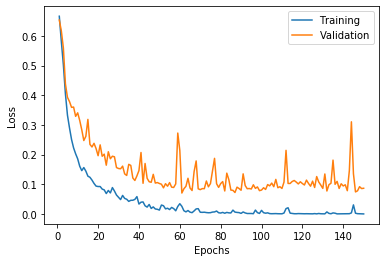

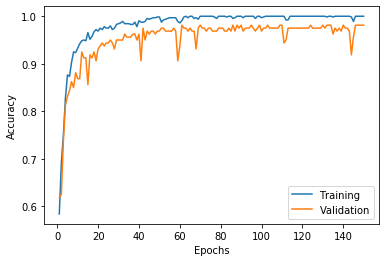

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

x_plot = list(range(1,len(network_history.epoch)+1))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
plot_history(network_history)

## Immagini con augmentation (manuale + generata automaticamente)

### Caricamento Dataset

In [0]:
immagini, labels = load_data("./Dataset_Fotografie_Cascade_2/")

100%|██████████| 1000/1000 [00:01<00:00, 659.96it/s]


###Train-Test Split

In [0]:
# Train-Test split (80-20)
x_train, x_test, y_train, y_test = train_test_split(immagini, labels, test_size=0.2, random_state=2020, shuffle = True)

print("Train shape: " + str(np.array(x_train).shape) + " " + str(np.array(y_train).shape))
print("Test shape: " + str(np.array(x_test).shape) + " " + str(np.array(y_test).shape))

Train shape: (800, 256, 256) (800,)
Test shape: (200, 256, 256) (200,)


### Augmentation del training set

In [0]:
# Creazione iteratore per immagini augmented
datagen = ImageDataGenerator(horizontal_flip=True,
                             rotation_range=20,
                             brightness_range=[0.2, 1.0])
datagen.fit(x_train.reshape(-1, 256, 256, 1), augment = True)
it = datagen.flow(x_train.reshape(-1, 256, 256, 1), y_train, batch_size=1)

#### Aggiunta immagini augmented

In [0]:
x_train_aug = []
y_train_aug = []

for i in tqdm(range(len(immagini))):
  batch = it.next()
  x_train_aug.append(batch[0].reshape(256,256))
  y_train_aug.append(batch[1][0])

100%|██████████| 1000/1000 [00:05<00:00, 193.86it/s]


<Figure size 720x720 with 0 Axes>

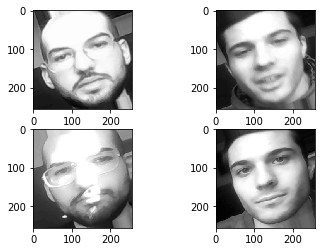

In [0]:
# print immagini di esempio
plt.figure(figsize=(10,10))
f, axarr = plt.subplots(2,2) 
axarr[0,0].imshow(x_train_aug[102], cmap = 'gray')
axarr[0,1].imshow(x_train_aug[138], cmap = 'gray')
axarr[1,0].imshow(x_train_aug[93], cmap = 'gray')
axarr[1,1].imshow(x_train_aug[211], cmap = 'gray')

In [0]:
# Unione tra immagini originali e augmented
x_train_aug = np.append(x_train.reshape(-1, 256, 256, 1), np.expand_dims(np.array(x_train_aug), -1), axis = 0)
y_train_aug = np.append(y_train, np.array(y_train_aug))

In [0]:
# Normalizzazione
x_train_aug = np.array(x_train_aug)/255.0
x_test = np.array(x_test)/255.0

# Reshape
x_train_aug = x_train_aug.reshape(-1, 256, 256, 1)
x_test = x_test.reshape(-1, 256, 256, 1)

### Modello CNN

In [0]:
input_shape = x_train_aug[0].shape

# Definizione modello
model = Sequential()

# Primo conv
model.add(Conv2D(32,
                 kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(AveragePooling2D((3, 3)))
model.add(Dropout(0.3))
# Secondo conv
model.add(Conv2D(16, kernel_size = (3, 3), activation="relu"))
model.add(AveragePooling2D((3, 3)))
model.add(Dropout(0.3))
# Terzo conv
model.add(Conv2D(8, kernel_size = (3, 3), activation="relu"))
model.add(AveragePooling2D((3, 3)))
model.add(Dropout(0.3))
# Quarto conv
model.add(Conv2D(8, kernel_size = (3, 3), activation="relu"))
model.add(AveragePooling2D((3, 3)))

# Flatten
model.add(Flatten())

# Dense
model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(2, activation = "softmax"))


print(model.summary())

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_103 (Conv2D)          (None, 254, 254, 32)      320       
_________________________________________________________________
average_pooling2d_28 (Averag (None, 84, 84, 32)        0         
_________________________________________________________________
dropout_93 (Dropout)         (None, 84, 84, 32)        0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 82, 82, 16)        4624      
_________________________________________________________________
average_pooling2d_29 (Averag (None, 27, 27, 16)        0         
_________________________________________________________________
dropout_94 (Dropout)         (None, 27, 27, 16)        0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 25, 25, 8)       

In [0]:
# Compilazione modello
model.compile(optimizer = keras.optimizers.Adam(lr=0.0001),
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

# Train e test modello
mcp_save = ModelCheckpoint('model-imm-aug-train(2).hdf5',
                          save_best_only=True,
                          monitor='val_loss',
                          mode='min')

network_history = model.fit(x_train_aug, y_train_aug,
                      batch_size= 32,
                      epochs= 500,
                      verbose = 1,
                      validation_split = 0.2,
                      callbacks = [mcp_save])

Train on 1440 samples, validate on 360 samples
Epoch 1/500
1440/1440 [==============================] - 4s 3ms/step - loss: 0.6907 - accuracy: 0.5403 - val_loss: 0.6929 - val_accuracy: 0.4889
Epoch 2/500
1440/1440 [==============================] - 3s 2ms/step - loss: 0.6785 - accuracy: 0.5688 - val_loss: 0.6922 - val_accuracy: 0.5694
Epoch 3/500
1440/1440 [==============================] - 3s 2ms/step - loss: 0.6661 - accuracy: 0.6299 - val_loss: 0.6913 - val_accuracy: 0.5194
Epoch 4/500
1440/1440 [==============================] - 3s 2ms/step - loss: 0.6503 - accuracy: 0.6438 - val_loss: 0.6893 - val_accuracy: 0.5639
Epoch 5/500
1440/1440 [==============================] - 3s 2ms/step - loss: 0.6376 - accuracy: 0.6521 - val_loss: 0.6864 - val_accuracy: 0.5889
Epoch 6/500
1440/1440 [==============================] - 3s 2ms/step - loss: 0.6215 - accuracy: 0.6583 - val_loss: 0.6824 - val_accuracy: 0.6000
Epoch 7/500
1440/1440 [==============================] - 3s 2ms/step - loss: 0.5993

#### Valutazione miglior modello

In [0]:
loaded_model = load_model("model-imm-aug-train(2).hdf5")
loaded_model.evaluate(x_test, y_test, verbose=0)

[0.005962515869177878, 1.0]

In [0]:
print(classification_report(y_test, loaded_model.predict_classes(x_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       103
           1       1.00      1.00      1.00        97

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



#### Grafico Train

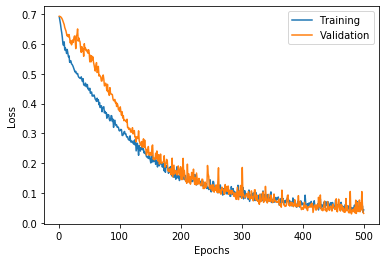

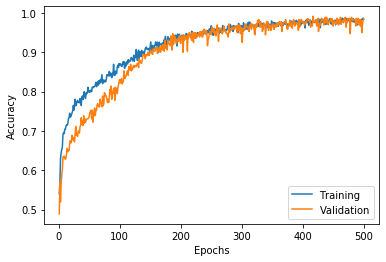

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

x_plot = list(range(1,len(network_history.epoch)+1))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
plot_history(network_history)

## Train modello definitivo con tutti i dati

### Augmentation dei dati

In [0]:
# Caricamento
immagini, labels = load_data("./Dataset_Fotografie_Cascade_2/")

# Creazione iteratore per immagini augmented
datagen = ImageDataGenerator(horizontal_flip=True,
                             rotation_range=20,
                             brightness_range=[0.2, 1.0])
datagen.fit(immagini.reshape(-1, 256, 256, 1), augment = True)
it = datagen.flow(immagini.reshape(-1, 256, 256, 1), labels, batch_size=1)

100%|██████████| 1000/1000 [00:01<00:00, 663.43it/s]


### Aggiunta immagini augmented

In [0]:
immagini_aug = []
labels_aug = []

for i in tqdm(range(len(immagini))):
  batch = it.next()
  immagini_aug.append(batch[0].reshape(256,256))
  labels_aug.append(batch[1][0])

100%|██████████| 1000/1000 [00:04<00:00, 234.33it/s]


In [0]:
# Unione tra immagini originali e augmented
immagini_aug = np.append(immagini.reshape(-1, 256, 256, 1), np.expand_dims(np.array(immagini_aug), -1), axis = 0)
labels_aug = np.append(labels, np.array(labels_aug))

# Normalizzazione
immagini_aug = np.array(immagini_aug)/255.0
# Reshape
immagini_aug = immagini_aug.reshape(-1, 256, 256, 1)

### Train Modello CNN

In [0]:
input_shape = x_train_aug[0].shape

# Definizione modello
model = Sequential()

# Primo conv
model.add(Conv2D(32,
                 kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(AveragePooling2D((3, 3)))
model.add(Dropout(0.3))
# Secondo conv
model.add(Conv2D(16, kernel_size = (3, 3), activation="relu"))
model.add(AveragePooling2D((3, 3)))
model.add(Dropout(0.3))
# Terzo conv
model.add(Conv2D(8, kernel_size = (3, 3), activation="relu"))
model.add(AveragePooling2D((3, 3)))
model.add(Dropout(0.3))
# Quarto conv
model.add(Conv2D(8, kernel_size = (3, 3), activation="relu"))
model.add(AveragePooling2D((3, 3)))

# Flatten
model.add(Flatten())

# Dense
model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(2, activation = "softmax"))


print(model.summary())

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 254, 254, 32)      320       
_________________________________________________________________
average_pooling2d_65 (Averag (None, 84, 84, 32)        0         
_________________________________________________________________
dropout_79 (Dropout)         (None, 84, 84, 32)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 82, 82, 16)        4624      
_________________________________________________________________
average_pooling2d_66 (Averag (None, 27, 27, 16)        0         
_________________________________________________________________
dropout_80 (Dropout)         (None, 27, 27, 16)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 25, 25, 8)       

In [0]:
# Compilazione modello
model.compile(optimizer = keras.optimizers.Adam(lr=0.0001),
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

# Train e test modello
mcp_save = ModelCheckpoint('model-aug-tot(2).hdf5',
                          save_best_only=True,
                          monitor='val_loss',
                          mode='min')

network_history = model.fit(immagini_aug, labels_aug,
                      batch_size= 32,
                      epochs= 1000,
                      verbose = 1,
                      validation_split = 0.2,
                      callbacks = [mcp_save])

Train on 1600 samples, validate on 400 samples
Epoch 1/1000
1600/1600 [==============================] - 2s 1ms/step - loss: 0.7233 - accuracy: 0.5031 - val_loss: 0.6925 - val_accuracy: 0.6225
Epoch 2/1000
1600/1600 [==============================] - 1s 826us/step - loss: 0.6882 - accuracy: 0.5475 - val_loss: 0.6923 - val_accuracy: 0.5675
Epoch 3/1000
1600/1600 [==============================] - 1s 831us/step - loss: 0.6679 - accuracy: 0.5750 - val_loss: 0.6910 - val_accuracy: 0.5975
Epoch 4/1000
1600/1600 [==============================] - 1s 827us/step - loss: 0.6467 - accuracy: 0.6106 - val_loss: 0.6896 - val_accuracy: 0.5800
Epoch 5/1000
1600/1600 [==============================] - 1s 827us/step - loss: 0.6414 - accuracy: 0.6306 - val_loss: 0.6869 - val_accuracy: 0.5900
Epoch 6/1000
1600/1600 [==============================] - 1s 830us/step - loss: 0.6331 - accuracy: 0.6413 - val_loss: 0.6847 - val_accuracy: 0.5925
Epoch 7/1000
1600/1600 [==============================] - 1s 841us/

#### Grafico Train

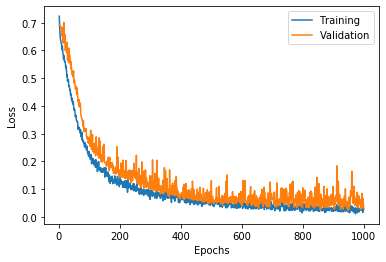

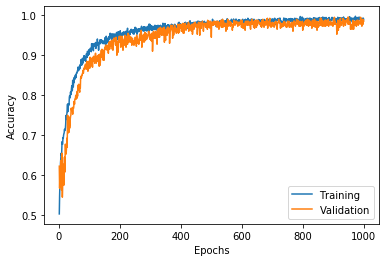

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

x_plot = list(range(1,len(network_history.epoch)+1))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
plot_history(network_history)

## Calcolo delle features per classe di rigetto

### Taglio rete al primo Dense

In [0]:
model_enc = Model(input = model.input,
                     output = model.get_layer('dense_1').output)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("co..., outputs=Tensor("de...)`
  


In [0]:
model_enc.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2_input (InputLayer)  (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 254, 254, 32)      320       
_________________________________________________________________
average_pooling2d_1 (Average (None, 84, 84, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 84, 84, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 82, 82, 16)        4624      
_________________________________________________________________
average_pooling2d_2 (Average (None, 27, 27, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 27, 27, 16)        0   

### Caricamento immagini

In [0]:
# Caricamento
immagini, labels = load_data()
# Normalizzazione
immagini = np.array(immagini)/255.0
# Reshape
immagini = immagini.reshape(-1, 256, 256, 1)

100%|██████████| 799/799 [00:01<00:00, 742.62it/s]


### Predict con encoder

In [0]:
# Creazione features immagini
features_enc = model_enc.predict(immagini)

In [0]:
#Calcolo media per Dario e Paolo
lista = list(zip(features_enc, labels))

lista_dario = []
lista_paolo = []

# Aggiunta delle features relative alla classe corrispondente
for i in lista:
  if i[-1] == 0:
    lista_dario.append(i[:-1])
  else:
    lista_paolo.append(i[:-1])

# Calcolo media delle features per ogni classe
media_dario = np.mean(np.array(lista_dario), axis = 0)
media_paolo = np.mean(np.array(lista_paolo), axis = 0)

# Salvataggio medie su Drive
'''
joblib.dump(media_dario, "/content/drive/My Drive/Progetto DSIM/Video/Image retrieval/KDTree e Dataset/media_dario_mymodel.joblib")
joblib.dump(media_paolo, "/content/drive/My Drive/Progetto DSIM/Video/Image retrieval/KDTree e Dataset/media_paolo_mymodel.joblib")
'''

['/content/drive/My Drive/Progetto DSIM/Video/Image retrieval/KDTree e Dataset/media_paolo_mymodel.joblib']